In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.2 MB/s eta 0:00:00


In [3]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
# from keras import layers
import keras

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
input_shape = (32, 32, 3)
num_classes = 7
Images = []
Labels = []
for j in range(7):
  print(j)
  driver = os.listdir("/content/drive/MyDrive/FER2013_dataset/train" + "/" + str(j))
  for i in driver:
        try:
            image = cv2.imread("/content/drive/MyDrive/FER2013_dataset/train/"+ str(j)+"/"+str(i))
            images = Image.fromarray(image)
            images = images.resize((32,32))
            images = np.array(images)
            images = images/255
            Images.append(images)
            Labels.append(j)
        except AttributeError:
          print('Error')

print("also add test files")

for j in range(7):
  print(j)
  driver = os.listdir("/content/drive/MyDrive/FER2013_dataset/test" + "/" + str(j))
  for i in driver:
        try:
            image = cv2.imread("/content/drive/MyDrive/FER2013_dataset/test/"+ str(j)+"/"+str(i))
            images = Image.fromarray(image)
            images = images.resize((32,32))
            images = np.array(images)
            images = images/255
            Images.append(images)
            Labels.append(j)
        except AttributeError:
          print('Error')

0
1
2
3
4
5
6
also add test files
0
1
2
3
4
5
6


In [5]:
Images = np.array(Images)
print(Images.shape)
Labels = np.array(Labels)
print(Labels.shape)


(35887, 32, 32, 3)
(35887,)


In [6]:

x_train, x_test, y_train, y_test = train_test_split(Images, Labels, train_size = 0.8,test_size=0.2, random_state=42, stratify=Labels)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (28709, 32, 32, 3) - y_train shape: (28709, 7)
x_test shape: (7178, 32, 32, 3) - y_test shape: (7178, 7)


In [21]:
positional_emb = True
conv_layers = 2
projection_dim = 128

num_heads = 2
transformer_units = [
    projection_dim,
    projection_dim,
]
transformer_layers = 2
stochastic_depth_rate = 0.1

learning_rate = 0.0001
weight_decay = 0.0001
batch_size = 128
num_epochs = 100
image_size = 32

In [8]:

class CCTTokenizer(layers.Layer):
    def __init__(
        self,
        kernel_size=3,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=2,
        num_conv_layers=conv_layers,
        num_output_channels=[64, 128],
        positional_emb=positional_emb,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # This is our tokenizer.
        self.conv_model = models.Sequential()
        for i in range(num_conv_layers):
            self.conv_model.add(
                layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="valid",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                )
            )
            self.conv_model.add(layers.ZeroPadding2D(padding))
            self.conv_model.add(
                layers.MaxPooling2D(pooling_kernel_size, pooling_stride, "same")
            )

        self.positional_emb = positional_emb

    def call(self, images):
        # if len(images.shape) == 3:
        #     images = tf.expand_dims(images, axis=-1)

        outputs = self.conv_model(images)
        # After passing the images through our mini-network the spatial dimensions
        # are flattened to form sequences.
        reshaped = tf.reshape(
            outputs,
            (
                -1,
                tf.shape(outputs)[1] * tf.shape(outputs)[2],
                tf.shape(outputs)[-1]
            )
        )
        # print(f"Tokenizer output shape: {reshaped.shape}")  # Debug statement
        return reshaped


In [9]:

class PositionEmbedding(keras.layers.Layer):
    def __init__(
        self,
        sequence_length,
        initializer="glorot_uniform",
        **kwargs,
    ):
        super().__init__(**kwargs)
        if sequence_length is None:
            raise ValueError("`sequence_length` must be an Integer, received `None`.")
        self.sequence_length = int(sequence_length)
        self.initializer = keras.initializers.get(initializer)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "initializer": keras.initializers.serialize(self.initializer),
            }
        )
        return config

    def build(self, input_shape):
        feature_size = input_shape[-1]
        self.position_embeddings = self.add_weight(
            name="embeddings",
            shape=[self.sequence_length, feature_size],
            initializer=self.initializer,
            trainable=True,
        )

        super().build(input_shape)

    def call(self, inputs, start_index=0):
        shape = tf.shape(inputs)
        feature_length = shape[-1]
        sequence_length = shape[-2]
        # trim to match the length of the input sequence, which might be less
        # than the sequence_length of the layer.
        position_embeddings = tf.convert_to_tensor(self.position_embeddings)
        position_embeddings = tf.slice(
            position_embeddings,
            (start_index, 0),
            (sequence_length, feature_length),
        )
        return tf.broadcast_to(position_embeddings, shape)

    def compute_output_shape(self, input_shape):
        return input_shape


In [10]:

class SequencePooling(layers.Layer):
    def __init__(self):
        super().__init__()
        self.attention = layers.Dense(1)

    def call(self, x):
        attention_weights = tf.nn.softmax(self.attention(x), axis=1)
        attention_weights = tf.transpose(attention_weights, perm=[0, 2, 1])
        weighted_representation = tf.matmul(attention_weights, x)
        return tf.squeeze(weighted_representation, axis=-2)


In [11]:

# Referred from: github.com:rwightman/pytorch-image-models.
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prop
        self.seed_generator = tf.random.set_seed(1337)

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (len(x.shape) - 1)
            random_tensor = keep_prob + tf.random.uniform(
                shape, 0, 1, seed=self.seed_generator
            )
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x


In [12]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = tf.keras.layers.Dense(units, activation=tfa.activations.gelu)(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x

In [16]:
# Note the rescaling layer. These layers have pre-defined inference behavior.
data_augmentation = models.Sequential(
    [
        layers.Rescaling(scale=1.0 / 255),
        layers.RandomCrop(image_size, image_size),
        layers.RandomFlip("horizontal"),
        # layers.RandomRotation(0.2),  # Add rotation
        # layers.RandomZoom(0.2),
    ],
    name="data_augmentation",

    )

In [20]:

def create_cct_model(
    image_size=image_size,
    input_shape=input_shape,
    num_heads=num_heads,
    projection_dim=projection_dim,
    transformer_units=transformer_units,
):
    inputs = layers.Input(input_shape)

    augmented = data_augmentation(inputs)

    # base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    # base_model.trainable = False  # Freeze the ResNet50 layers

    # # Use the ResNet model to extract features
    # x = base_model(augmented, training=False)
    # x = GlobalAveragePooling2D()(x)  # Pool the features

    # reshape_layer = layers.Lambda(lambda new: tf.reshape(new, [-1, 1, 2048]))
    # x = reshape_layer(x)

    # Encode patches.
    cct_tokenizer = CCTTokenizer()
    # encoded_patches = cct_tokenizer(x)
    encoded_patches = cct_tokenizer(augmented)

    # Apply positional embedding.
    if positional_emb:
        sequence_length = encoded_patches.shape[1]
        encoded_patches += PositionEmbedding(sequence_length=sequence_length)(
            encoded_patches
        )

    # Calculate Stochastic Depth probabilities.
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

         # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.2
        )(x1, x1)

        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)

        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)


        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.2)

        # Skip connection 2.
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = layers.Add()([x3, x2])


    # Apply sequence pooling.
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    weighted_representation = SequencePooling()(representation)
    # features = layers.Flatten()(weighted_representation)
    # features = layers.Dropout(0.4)(features)

    # Classify outputs.
    # logits = layers.Dense(num_classes, kernel_regularizer=regularizers.l2(weight_decay))(weighted_representation)
    logits = layers.Dense(num_classes)(weighted_representation)
    # Create the Keras model.
    model = models.Model(inputs=inputs, outputs=logits)
    return model



In [22]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.CategoricalCrossentropy(
            from_logits=True, label_smoothing=0.1
        ),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )
    # early_stopping_callback = keras.callbacks.EarlyStopping(
    #     monitor='val_loss', patience=10, restore_best_weights=True)

    # history = model.fit(
    #     x=x_train,
    #     y=y_train,
    #     batch_size=batch_size,
    #     epochs=num_epochs,
    #     validation_split=0.1,
    #     callbacks=[checkpoint_callback, early_stopping_callback],
    # )
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


cct_model = create_cct_model()
history = run_experiment(cct_model)

Epoch 1/100
202/202 [==============================] - 13s 42ms/step - loss: 1.8678 - accuracy: 0.2258 - top-5-accuracy: 0.8565 - val_loss: 1.8390 - val_accuracy: 0.2630 - val_top-5-accuracy: 0.8680
Epoch 2/100
202/202 [==============================] - 8s 41ms/step - loss: 1.8536 - accuracy: 0.2411 - top-5-accuracy: 0.8631 - val_loss: 1.8199 - val_accuracy: 0.2619 - val_top-5-accuracy: 0.9046
Epoch 3/100
202/202 [==============================] - 7s 36ms/step - loss: 1.8389 - accuracy: 0.2407 - top-5-accuracy: 0.8857 - val_loss: 1.8129 - val_accuracy: 0.2696 - val_top-5-accuracy: 0.9039
Epoch 4/100
202/202 [==============================] - 8s 38ms/step - loss: 1.8308 - accuracy: 0.2465 - top-5-accuracy: 0.8886 - val_loss: 1.8135 - val_accuracy: 0.2665 - val_top-5-accuracy: 0.9018
Epoch 5/100
202/202 [==============================] - 8s 37ms/step - loss: 1.8288 - accuracy: 0.2502 - top-5-accuracy: 0.8919 - val_loss: 1.8096 - val_accuracy: 0.2682 - val_top-5-accuracy: 0.9000
Epoch 6/1

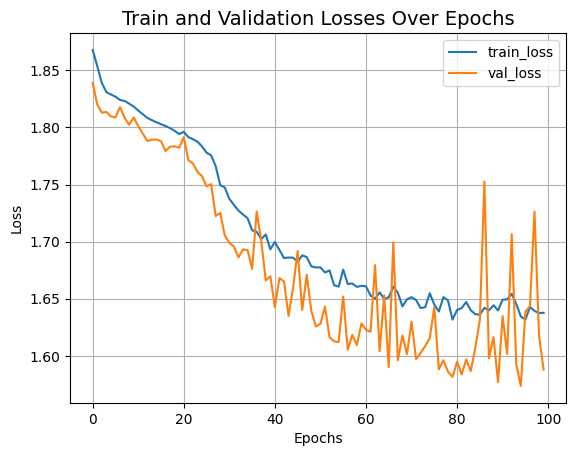

In [23]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()